# Learning outcomes
- Image histogram
- Histogram equalization / CLAHE:
    * purpose: contrast enhancement (same effect as simple scalar multiplication)
- Thresholding (end results: binary mask with 255 as foreground)
- Morphological operations (manipulate the mask)
    - Erosion
    - Dilation
    - Opening
    - Closing
- Color spaces: RGB, HSV and L\*a*\*b
- Color based segmentation (HSV). Hue represents color, one channel encode color information.

## Setup

In [1]:
import sys
assert sys. version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist,_ = np.histogram(gray.flatten(), 256)

41 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.06 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


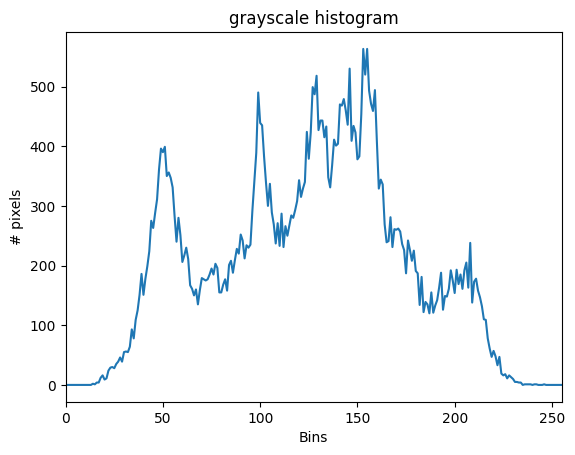

In [4]:
# construct histogram 
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

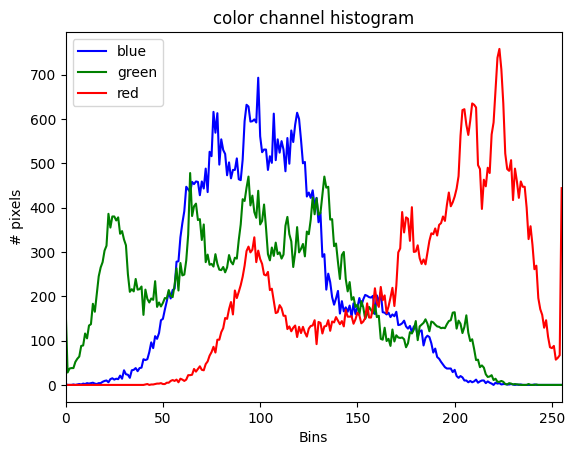

In [5]:
# compute histogram for all the channels
channels = cv.split(img)
colors = ("blue", "green", "red")

plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()
    

## Histogram equalization

In [6]:
img = cv.imread("images/low_contrast_img.jfif")
show_img("low_contrast", img)

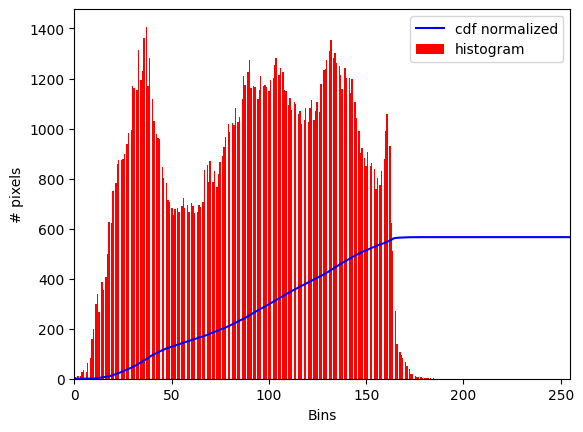

In [7]:
# histogram
hist = cv.calcHist([img], [0], None, [256], [0, 256])

# compute cdf
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.show()

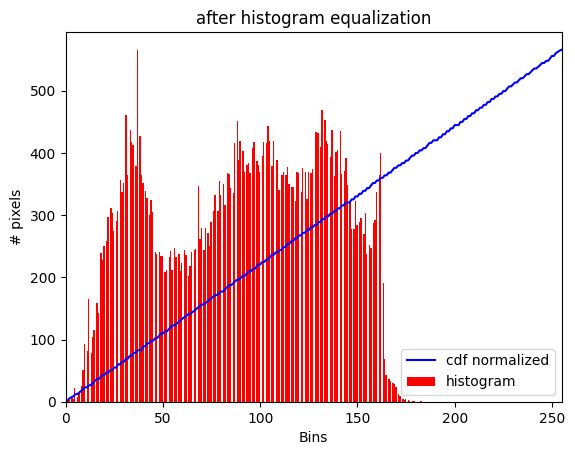

In [8]:
# histogram equalization
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])

# compute cdf
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.title("after histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.show()

In [9]:
cv.imshow("original", img)
show_img("equalization", eq)

In [10]:
# 
img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)

# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Exercise 1

In [11]:
img = cv.imread("images/winter.jfif", 0)

# equalization
eq = cv.equalizeHist(img)

# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Thresholding

In [12]:
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [13]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Comparison on the thresholding methods

In [14]:
img = cv.imread("images/noisy.jfif", 0)
show_img("noisy image", img)

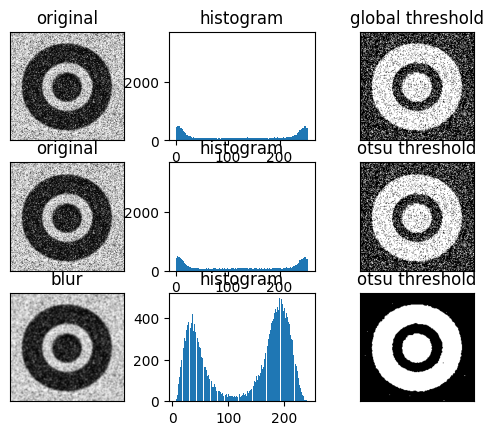

In [15]:
# apply 3 methods
# 1. global threshold
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]


# 2. OTSU threshold
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

# 3. Gaussian blur + otsu threshold
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1, 
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "histogram", "otsu threshold",
         "blur", "histogram", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Exercise

In [16]:
img = cv.imread("images/wood_planck.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

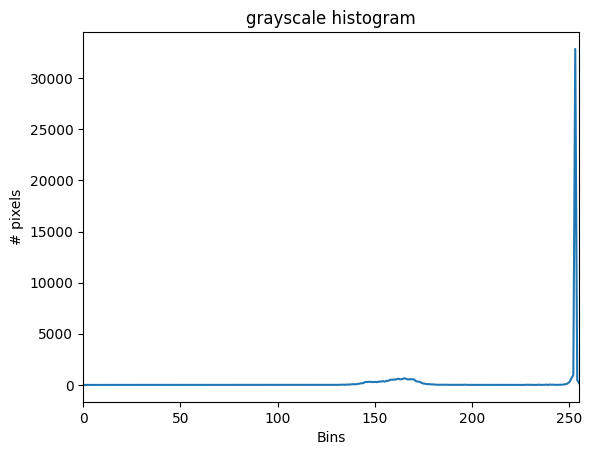

In [17]:
# construct histogram 
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

In [18]:
img = cv.imread("images/wood_planck.jfif", 0)
show_img("wood planck", img)

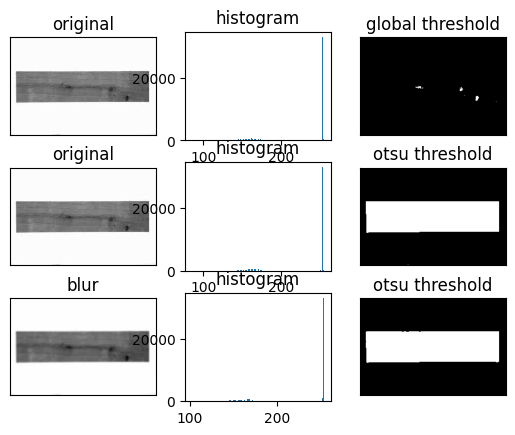

In [19]:
# apply 3 methods
# 1. global threshold
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]


# 2. OTSU threshold
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

# 3. Gaussian blur + otsu threshold
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1, 
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "histogram", "otsu threshold",
         "blur", "histogram", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Morphological operations
- erosion
- dilation
- opening (erosion + dilation)
- closing (dilation + erosion)

In [20]:
# define structuring element
kernel = np.ones((3, 3), dtype=np.uint8)

# erosion
dst = cv.dilate(th3, kernel, iterations=1)

# show
img_combined = np.hstack((th3, dst))

show_img("dilate", img_combined)

In [23]:
# trackbar
def nothing(x):
    pass

wn = 'window'
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
    
    # define the kernel
    kernel = np.ones((size, size), dtype=np.uint8)
    # erosion
    erosion = cv.erode(th3, kernel, iterations=iteration)
    
    cv.imshow(wn, erosion)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

In [24]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (8, 8))

In [25]:
# Closing
res = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations=2)

img_combines = np.hstack((th3, res))

show_img("closing", img_combined)

## Color spaces
- RGB (the most prevalent color space. Any picture is stored under this format, but the donwside of this color space is that there is no clear way to separate chroma (color and ots saturation)). Not suitable for color based segmentation. 
- HSV (Hue, Saturation, value)
    - Hue -> color (make use of hue to segment color)
    - saturation -> purity of color
    - value -> brightness / luminance
- LAB
    - perceptual uniformity (the Euclidean distance in the color spcae corresponds to perceptual uniformity).

In [26]:
# image sharpening with LAB
#1: split image into L, a, b 
#2: sharpen the L channel
#3: merge color channels

img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
l, a, b = cv.split(img_lab)

# define sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpened = cv.filter2D(l, -1, kernel)

# mege
img_lab_merge = cv.merge((l_sharpened, a, b))
dst = cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", dst)

## demo on color based segmentation

In [27]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

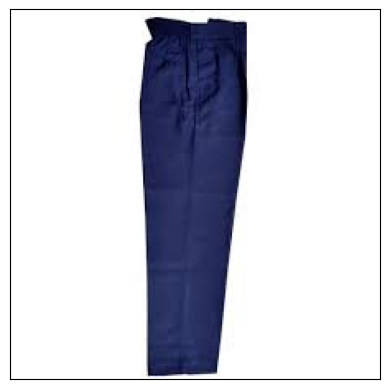

In [28]:
plt_img(img)
plt.show()

### Show the pixels in rgb color space

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

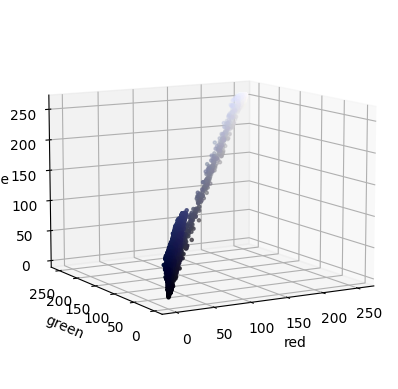

In [30]:
# split the color channels
r, g, b = cv.split(img)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection="3d")

# encode the color information
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axes.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=240)
axes.set_xlabel("red")
axes.set_ylabel("green")
axes.set_zlabel("blue")
plt.show()

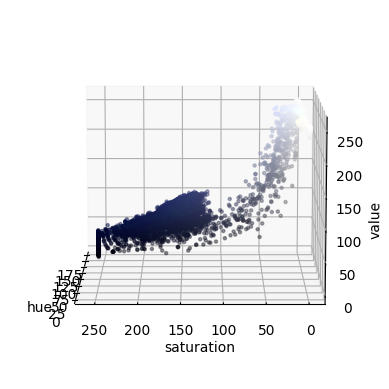

In [31]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection="3d")

axes.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=180)
axes.set_xlabel("hue")
axes.set_ylabel("saturation")
axes.set_zlabel("value")
plt.show()

(<Axes: >, None)

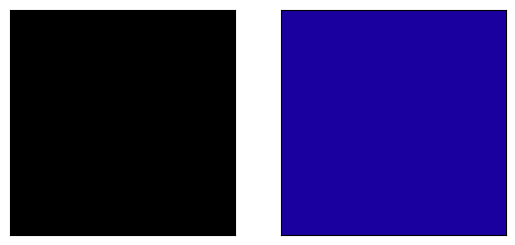

In [9]:
# h: 85 - 125
# s: 90 - 255
# v: 0 - 160
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))

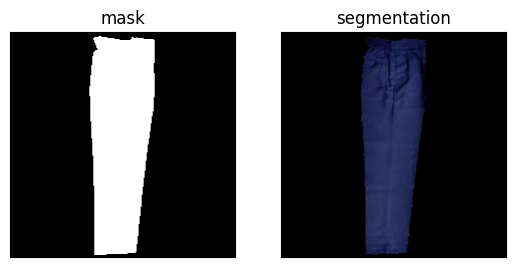

In [33]:
#color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)

plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation")
plt.show()

## Exercise

In [34]:
def color_seg(img, color_low, color_high, smooth=True):
    """Aguments
    img: source image (RGB)
    color_low: hsv low
    color_high: hsv high
    smooth: boolean (Gaussian blurring)"""
    img_ori = img.copy()
    if smooth: 
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask = cv.inRange(img_hsv, color_low, color_high)
    # morphological operations
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    res = cv.bitwise_and(img_ori, img_ori, mask=mask)
    return res

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

res = [color_seg(img, blue_low, blue_high) for img in imgs]

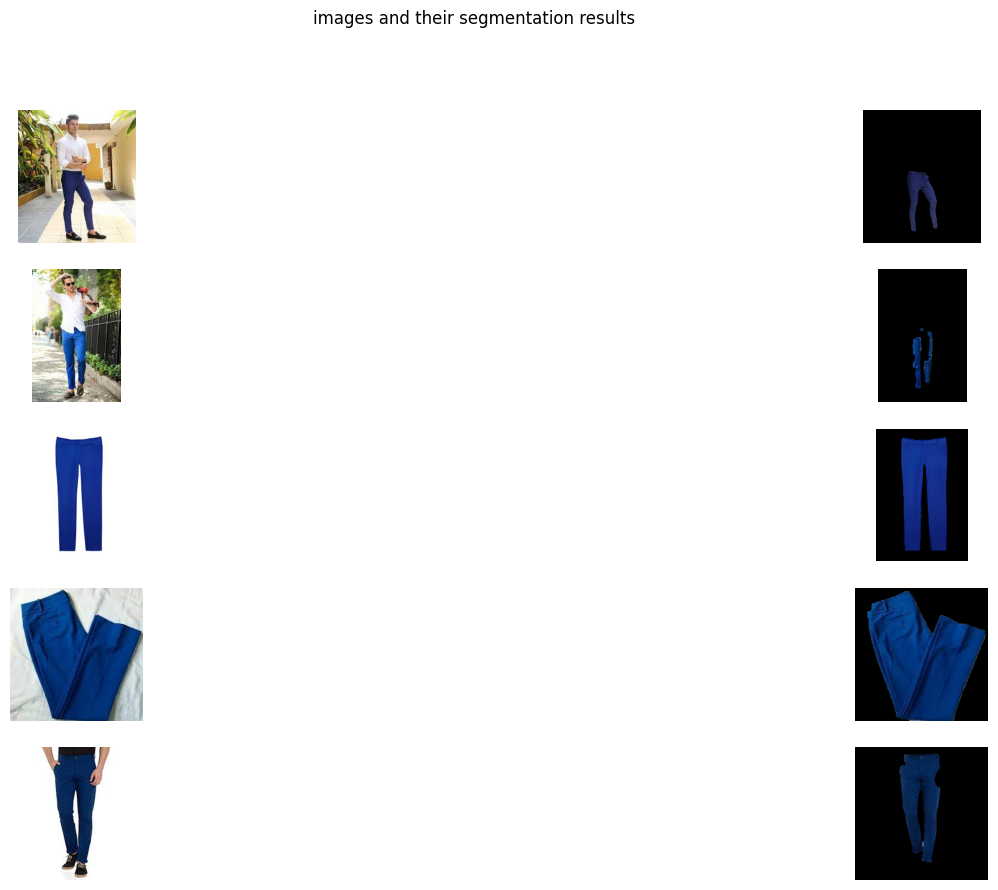

In [35]:
fig, ax = plt.subplots(5, 2, figsize=(20, 10))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("images and their segmentation results")
plt.show()

## Weekly activity

## Q1

In [2]:
img = cv.imread("images/boat.jpg", 0)
show_img("boat", img)

In [3]:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

In [4]:
# Find contours in the binary image
contours, _ = cv.findContours(th2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around the regions with boat and people
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the segmented image with bounding boxes
cv.imshow('Segmented Image', img)
cv.waitKey(0)
cv.destroyAllWindows()

## Q2

In [5]:
img = cv.imread("images/leaf.jfif", 0)
show_img("leaf", img)

In [6]:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

In [7]:
# trackbar
def nothing(x):
    pass

wn = 'window'
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
    
    # define the kernel
    kernel = np.ones((size, size), dtype=np.uint8)
    # erosion
    erosion = cv.erode(th2, kernel, iterations=iteration)
    
    cv.imshow(wn, erosion)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

## Q3

In [8]:
blue_low = (90, 50, 50)
blue_high = (130, 255, 255)

white_low = (0, 0, 200)
white_high = (180, 30, 255)

In [9]:
def color_seg(img, color_low, color_high, color_low2, color_high2, smooth=True):
    """Aguments
    img: source image (RGB)
    color_low: hsv low
    color_high: hsv high
    smooth: boolean (Gaussian blurring)"""
    img_ori = img.copy()
    if smooth: 
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask2 = cv.inRange(img_hsv, color_low2, color_high2)
    
    segmented_mask = cv.bitwise_or(mask, mask2)
    res = cv.bitwise_and(img_ori, img_ori, mask=segmented_mask)
    return res

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

res = [color_seg(img, blue_low, blue_high, white_low, white_high) for img in imgs]

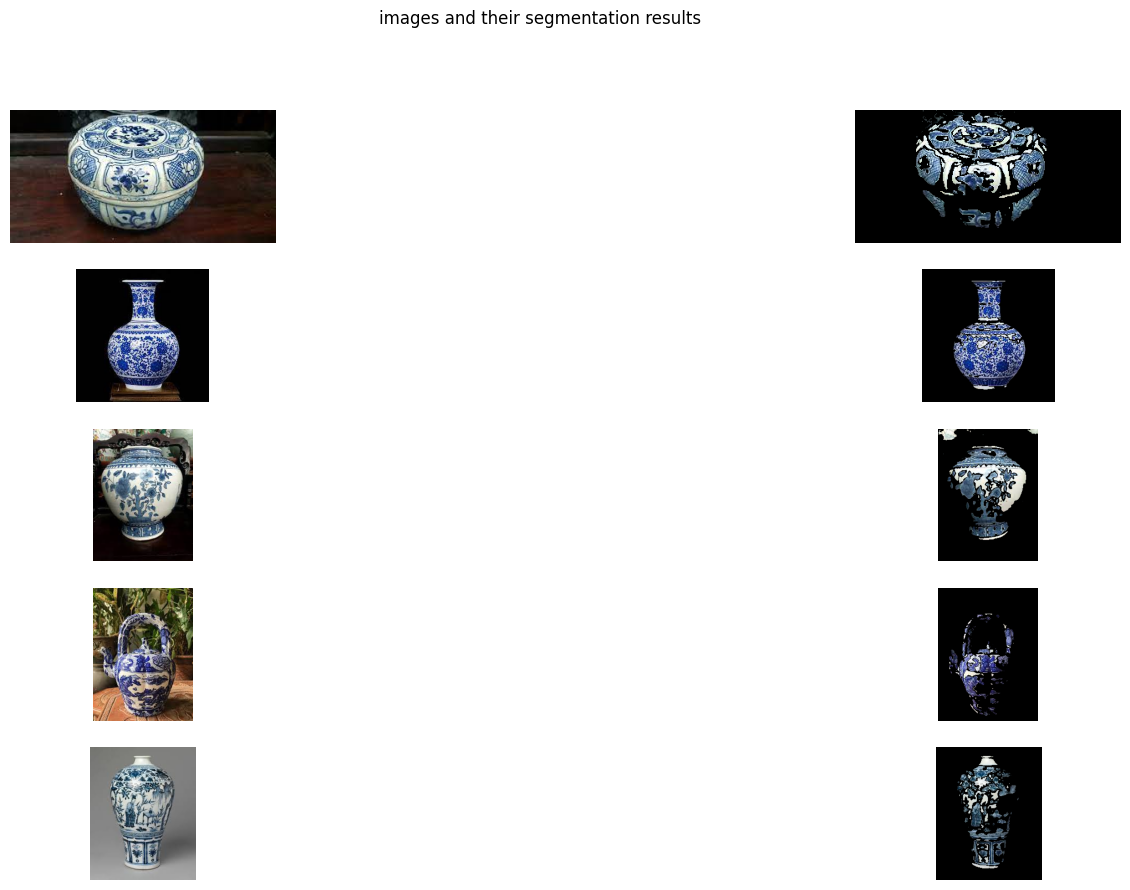

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(20, 10))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("images and their segmentation results")
plt.show()